In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import isect_segments_bentley_ottmann.poly_point_isect as bot

In [ ]:
# img = cv2.imread('example.jpg')
img = cv2.imread('example_upscale.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.imread('example_upscale.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('example_crosses.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=img)
plt.title(f'img {len(img)}')
plt.show()

In [ ]:

kernel_size = 3
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=blur_gray)
plt.title(f'blur_gray {len(blur_gray)}')
plt.show()

In [ ]:
low_threshold = 20
high_threshold = 150

edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=edges)
plt.title(f'edges {len(edges)}')
plt.show()
np.argwhere(edges[:,:] > 100)

In [ ]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

In [ ]:
points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1 + 0.0, y1 + 0.0), (x2 + 0.0, y2 + 0.0)))
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

print(lines_edges.shape)
plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=lines_edges)
plt.title(f'lines_edges {len(lines_edges)}')
plt.show()

# print(lines_edges)
#cv2.imwrite('line_parking.png', lines_edges)

# intersections = bot.isect_segments(points)
# print(intersections)

In [ ]:
for intersection in intersections:
    a, b = intersection
    for i in range(3):
        for j in range(3):
            lines_edges[int(b) + i, int(a) + j] = [0, 255, 0]
#             print(lines_edges[int(b) + i, int(a) + j])

# print(lines_edges)
cv2.imwrite('line_parking.png', lines_edges)

plt.figure(figsize=(8, 8), dpi=90)
plt.imshow(X=lines_edges)
plt.title(f'lines_edges {len(lines_edges)}')
plt.show()

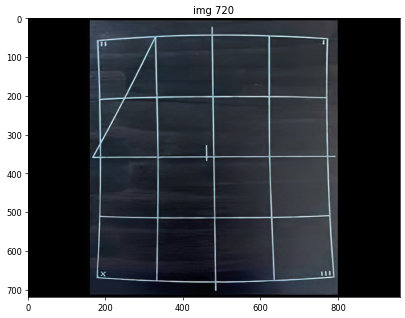

In [80]:
# img = cv2.imread('example.jpg')
img = cv2.imread('example_upscale.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img = cv2.imread('example_upscale.jpg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('example_crosses.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=img)
plt.title(f'img {len(img)}')
plt.show()

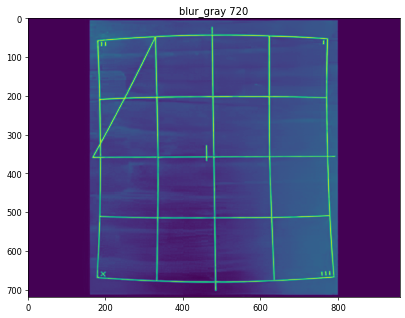

In [81]:

kernel_size = 3
blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=blur_gray)
plt.title(f'blur_gray {len(blur_gray)}')
plt.show()

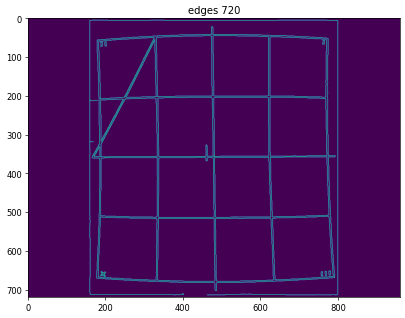

array([[  5, 165],
       [  5, 166],
       [  5, 167],
       ...,
       [714, 795],
       [714, 796],
       [714, 797]], dtype=int64)

In [82]:
low_threshold = 20
high_threshold = 150

edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=edges)
plt.title(f'edges {len(edges)}')
plt.show()
np.argwhere(edges[:,:] > 100)

In [83]:
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 5  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5  # minimum number of pixels making up a line
max_line_gap = 40  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

(720, 960, 3)


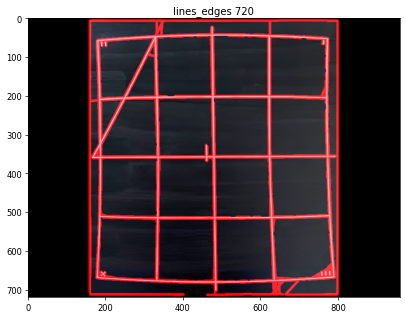

In [84]:
points = []
for line in lines:
    for x1, y1, x2, y2 in line:
        points.append(((x1 + 0.0, y1 + 0.0), (x2 + 0.0, y2 + 0.0)))
        cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

print(lines_edges.shape)
plt.figure(figsize=(8, 8), dpi=60)
plt.imshow(X=lines_edges)
plt.title(f'lines_edges {len(lines_edges)}')
plt.show()

# print(lines_edges)
#cv2.imwrite('line_parking.png', lines_edges)

# intersections = bot.isect_segments(points)
# print(intersections)

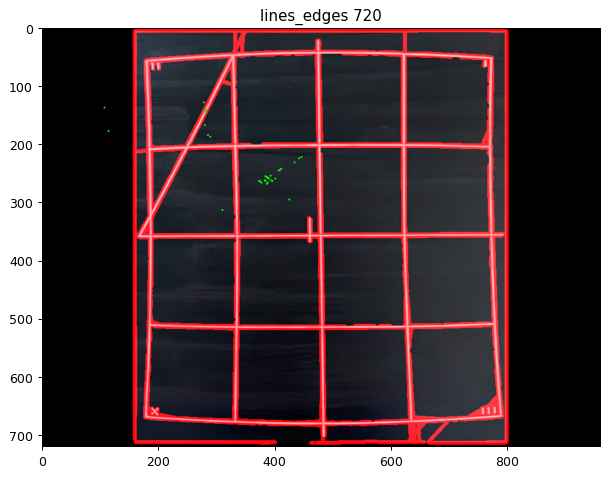

In [87]:
for intersection in intersections:
    a, b = intersection
    for i in range(3):
        for j in range(3):
            lines_edges[int(b) + i, int(a) + j] = [0, 255, 0]
#             print(lines_edges[int(b) + i, int(a) + j])

# print(lines_edges)
cv2.imwrite('line_parking.png', lines_edges)

plt.figure(figsize=(8, 8), dpi=90)
plt.imshow(X=lines_edges)
plt.title(f'lines_edges {len(lines_edges)}')
plt.show()